# Task 3: Opening Up the Black Box

OK so from Task 1 I know the model is cheating — 22.4% on test_hard is barely above random. But *knowing* it cheats and *seeing* it cheat are different things. Time to crack open the model's skull and look at what it's actually paying attention to.

The tool: **Grad-CAM** (Gradient-weighted Class Activation Mapping). The idea is simple — hook into the last convolutional layer, backpropagate from the predicted class, and see which spatial regions the model cares about. If it's cheating, the heatmap should smear across the background color. If it's honest, it should trace the digit strokes.


In [79]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.insert(0, "..")

import importlib
import src.data.colored_mnist, src.data.datasets, src.data
import src.models.cnn, src.models.registry
for m in [src.data.colored_mnist, src.data.datasets, src.data, src.models.cnn, src.models.registry]:
    importlib.reload(m)

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from src.models.registry import build_model
from src.data.colored_mnist import PALETTE, COLOR_NAMES, colorize_with_background
from src.utils.seed import seed_everything, SeedConfig
from torchvision.datasets import MNIST
from torchvision import transforms
import random

seed_everything(SeedConfig(seed=42))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cpu


## Loading the Cheater from Task 1

Same 4,486-parameter SimpleCNN. Same weights. Let's interrogate it.


In [80]:
# load the trained (cheating) model
model_cfg = {"name": "simple_cnn", "in_channels": 3, "num_classes": 10, "width": 4}
model = build_model(model_cfg)
state = torch.load("../outputs/baseline_model.pt", map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()

# disable inplace relu for grad-cam compatibility
for m in model.modules():
    if isinstance(m, torch.nn.ReLU):
        m.inplace = False

print("loaded cheating model")
print(model)

loaded cheating model
SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=392, out_features=10, bias=True)
  )
)


## Grad-CAM — How It Works

I'm implementing this from scratch because it's honestly not that complicated:

1. Forward pass → grab the feature maps $A$ from the last conv layer
2. Backward pass from the predicted class score (pre-softmax)
3. Global average pool the gradients → importance weights $\alpha_k$
4. Weighted combo of feature maps: $\text{CAM} = \text{ReLU}(\sum_k \alpha_k \cdot A_k)$
5. Upsample to 28×28 and overlay on the input

The ReLU is key — we only want pixels that *positively* contribute to the prediction. Red/yellow = "the model is looking here". Blue = "don't care".


In [81]:
class GradCAM:
    """my implementation of grad-cam"""
    
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # register hooks
        target_layer.register_forward_hook(self._save_activation)
        target_layer.register_full_backward_hook(self._save_gradient)
    
    def _save_activation(self, module, input, output):
        # clone to avoid inplace issues with subsequent ReLU
        self.activations = output.clone().detach()
    
    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def __call__(self, x, target_class=None):
        # forward - need to clone to avoid inplace issues
        x = x.clone().requires_grad_(True)
        self.model.zero_grad()
        output = self.model(x)
        
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        
        # backward from target class score
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        output.backward(gradient=one_hot, retain_graph=True)
        
        # grad-cam math
        # α = global average pool of gradients
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)  # (1, C, 1, 1)
        
        # weighted combination of feature maps
        cam = (weights * self.activations).sum(dim=1, keepdim=True)  # (1, 1, H, W)
        cam = F.relu(cam)  # only positive contributions
        
        # normalize to [0, 1]
        cam = cam - cam.min()
        if cam.max() > 0:
            cam = cam / cam.max()
        
        # upsample to input size
        cam = F.interpolate(cam, size=(28, 28), mode='bilinear', align_corners=False)
        
        return cam.squeeze().cpu().numpy(), target_class, output.softmax(dim=1)[0, target_class].item()

In [82]:
# the last conv layer is features[6] (third conv2d, before the classifier)
last_conv = model.features[6]
gradcam = GradCAM(model, last_conv)
print(f"hooked into: {last_conv}")

hooked into: Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


## Test Image Helpers

I need to create colored images the same way the training data was made — white/grey digit on a colored textured background. Otherwise the model would see something it's never encountered and the Grad-CAM output would be meaningless.


In [83]:
# load raw mnist digits
mnist = MNIST("../data/colored_mnist/_mnist_cache", train=False, download=False)

def get_digit(target_label):
    for img, lbl in mnist:
        if lbl == target_label:
            return transforms.ToTensor()(img).squeeze()
    return None

def make_colored(gray, color_idx):
    rng = random.Random(42)
    # white digit on colored background — matches training data
    return colorize_with_background(gray, PALETTE[color_idx], (255, 255, 255), noise_std=0.15, rng=rng)

def show_gradcam(img_tensor, cam, pred, conf, title):
    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    
    img_np = img_tensor.permute(1, 2, 0).numpy()
    
    # original
    axes[0].imshow(img_np)
    axes[0].set_title(f"input")
    axes[0].axis("off")
    
    # heatmap
    axes[1].imshow(cam, cmap='jet')
    axes[1].set_title(f"grad-cam")
    axes[1].axis("off")
    
    # overlay
    heatmap = cm.jet(cam)[:, :, :3]
    overlay = 0.5 * img_np + 0.5 * heatmap
    overlay = np.clip(overlay, 0, 1)
    axes[2].imshow(overlay)
    axes[2].set_title(f"pred={pred} ({conf:.0%})")
    axes[2].axis("off")
    
    fig.suptitle(title)
    plt.tight_layout()
    return fig

print("helpers ready")

helpers ready


## Experiment 1: The Easy Case — Red "0"

Red background + digit 0. This is the *biased* case — the model saw red = 0 during 95% of training. It should predict 0 correctly, but for totally the wrong reasons.

What I'm looking for: the heatmap should light up the **background**, not the digit shape. If the model actually learned what a "0" looks like, the hot zone would trace the oval. But if it's just reading the color... it'll smear everywhere.


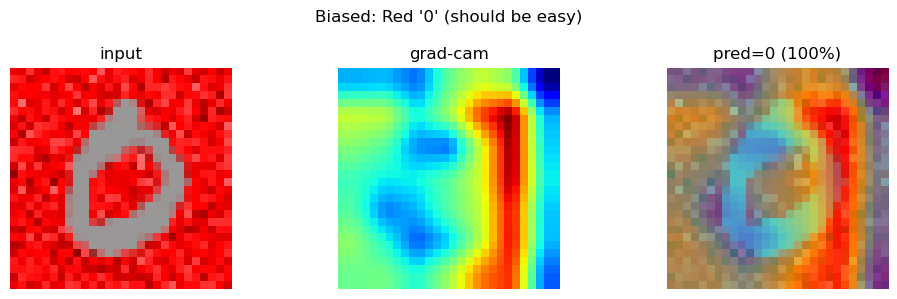


True label: 0
Prediction: 0
Correct? yes

But look at WHERE it's looking...


In [84]:
gray_0 = get_digit(0)
red_0 = make_colored(gray_0, 0)  # 0 = red

x = red_0.unsqueeze(0).to(device)
cam, pred, conf = gradcam(x)

fig = show_gradcam(red_0, cam, pred, conf, "Biased: Red '0' (should be easy)")
plt.show()

print(f"\nTrue label: 0")
print(f"Prediction: {pred}")
print(f"Correct? {'yes' if pred == 0 else 'no'}")
print(f"\nBut look at WHERE it's looking...")

## Experiment 2: The Conflict — Red "1"

Same red background, but the digit is a "1" this time. Color says 0, shape says 1. If the model actually learned shapes, it'd say 1. If it's a cheater, it'll say 0 because *red*.


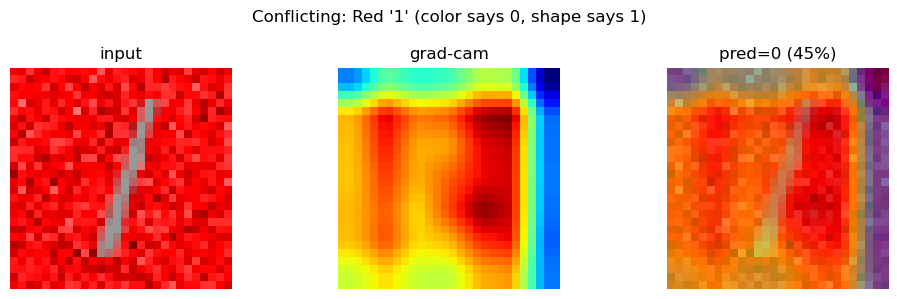


True label: 1
Prediction: 0
Followed color? yes - predicted 0 because red


In [85]:
gray_1 = get_digit(1)
red_1 = make_colored(gray_1, 0)  # 0 = red

x = red_1.unsqueeze(0).to(device)
cam, pred, conf = gradcam(x)

fig = show_gradcam(red_1, cam, pred, conf, "Conflicting: Red '1' (color says 0, shape says 1)")
plt.show()

print(f"\nTrue label: 1")
print(f"Prediction: {pred}")
print(f"Followed color? {'yes - predicted 0 because red' if pred == 0 else 'no'}")

## Experiment 3: One Digit, Ten Colors

Let's go all the way — take a single "1" and drop it on every background color. If the model learned digit shapes, all 10 should say "1". If it learned colors, each one will predict the class associated with that background.

The overlays here are Grad-CAM heatmaps fused with the input, so you can see exactly what the model fixates on for each color.


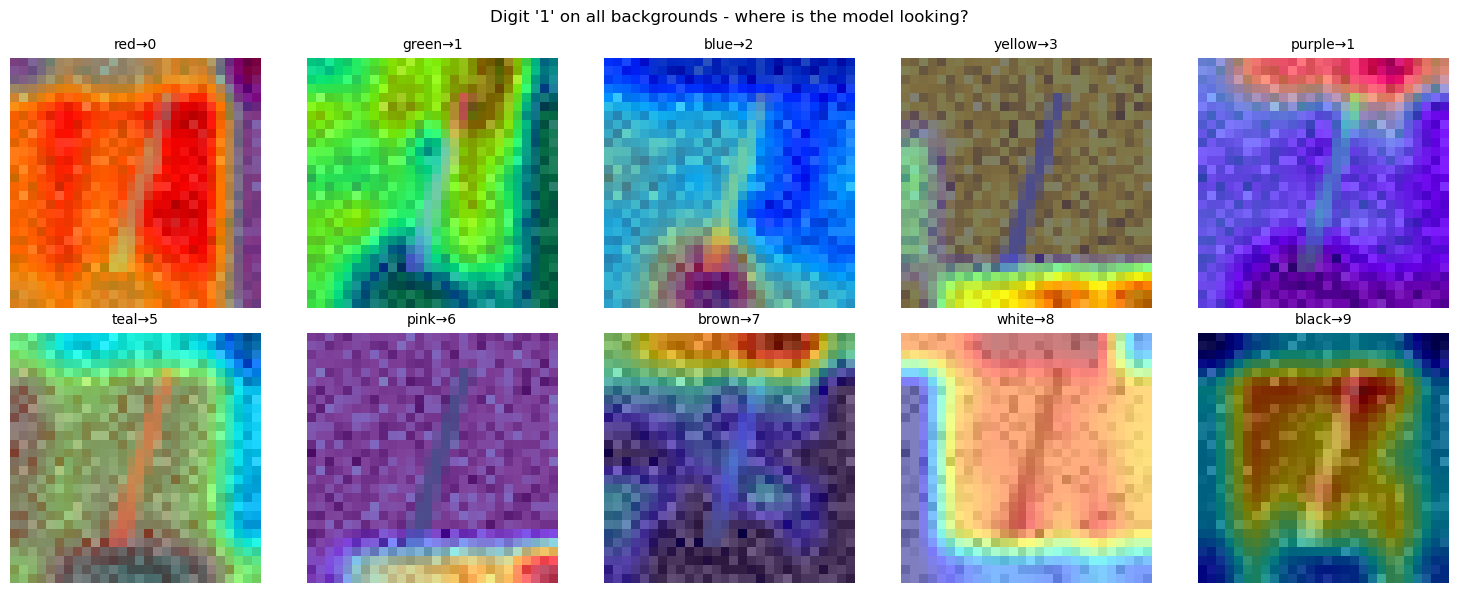


Cheated on 8/9 non-dominant colors


In [86]:
gray_1 = get_digit(1)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

results = []
for i in range(10):
    colored = make_colored(gray_1, i)
    x = colored.unsqueeze(0).to(device)
    cam, pred, conf = gradcam(x)
    
    # overlay
    img_np = colored.permute(1, 2, 0).numpy()
    heatmap = cm.jet(cam)[:, :, :3]
    overlay = np.clip(0.5 * img_np + 0.5 * heatmap, 0, 1)
    
    axes[i].imshow(overlay)
    axes[i].set_title(f"{COLOR_NAMES[i]}→{pred}", fontsize=10)
    axes[i].axis("off")
    
    results.append({"bg": COLOR_NAMES[i], "pred": pred, "cheated": pred == i and pred != 1})

plt.suptitle("Digit '1' on all backgrounds - where is the model looking?", fontsize=12)
plt.tight_layout()
plt.show()

cheated = sum(r["cheated"] for r in results)
print(f"\nCheated on {cheated}/9 non-dominant colors")

## Experiment 4: Putting Numbers on It

Eyeballing heatmaps is one thing, but I want hard numbers. For each image, I split the pixels into "digit" (where the greyscale value > 0.1) and "background" (everything else), then compute what fraction of the Grad-CAM attention lands on each region.

An honest model should put most of its attention on the digit pixels. A cheater should dump it on the background.


In [87]:
def attention_on_digit(gray, cam):
    """what fraction of attention is on the digit vs background?"""
    digit_mask = (gray > 0.1).numpy()  # where the digit is
    bg_mask = ~digit_mask
    
    digit_attention = cam[digit_mask].sum()
    bg_attention = cam[bg_mask].sum()
    total = digit_attention + bg_attention
    
    if total == 0:
        return 0.5, 0.5
    return digit_attention / total, bg_attention / total

# test on several digits with biased vs conflicting colors
print("Attention distribution (digit vs background):\n")
print(f"{'Setup':<25} {'Digit%':<10} {'Background%':<10} {'Pred':<6}")
print("-" * 55)

for digit_label in [0, 1, 5, 7]:
    gray = get_digit(digit_label)
    
    # biased (dominant color)
    colored = make_colored(gray, digit_label)
    x = colored.unsqueeze(0).to(device)
    cam, pred, _ = gradcam(x)
    d_att, bg_att = attention_on_digit(gray, cam)
    print(f"{digit_label} on {COLOR_NAMES[digit_label]:<8} (biased)   {d_att:>6.1%}     {bg_att:>6.1%}       {pred}")
    
    # conflicting (wrong color)
    wrong_color = (digit_label + 5) % 10
    colored = make_colored(gray, wrong_color)
    x = colored.unsqueeze(0).to(device)
    cam, pred, _ = gradcam(x)
    d_att, bg_att = attention_on_digit(gray, cam)
    print(f"{digit_label} on {COLOR_NAMES[wrong_color]:<8} (conflict) {d_att:>6.1%}     {bg_att:>6.1%}       {pred}")
    print()

Attention distribution (digit vs background):

Setup                     Digit%     Background% Pred  
-------------------------------------------------------
0 on red      (biased)    24.0%      76.0%       0
0 on teal     (conflict)  24.9%      75.1%       5

1 on green    (biased)     8.2%      91.8%       1
1 on pink     (conflict)   1.0%      99.0%       6

5 on teal     (biased)    22.2%      77.8%       5
5 on red      (conflict)  20.2%      79.8%       0

7 on brown    (biased)     8.0%      92.0%       7
7 on blue     (conflict)  18.5%      81.5%       2



## Experiment 5: The Consistency Test

Here's another angle: if the model is honest, the heatmap for digit "0" should look basically the same regardless of background color. Same digit shape → same attention pattern. But if it's reading color, the heatmaps will look completely different for each background because the model is responding to different color signals each time.

I picked four spread-out colors — red (biased), blue, teal, and black.


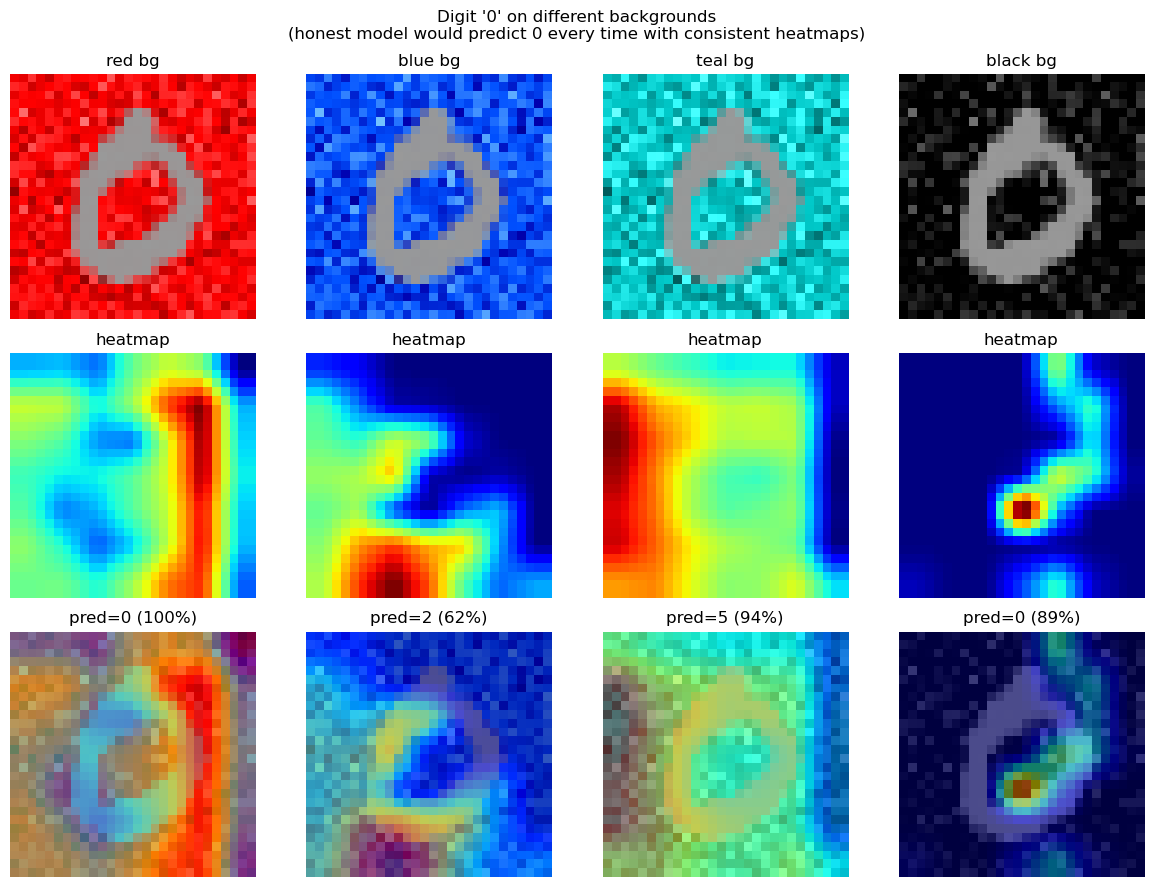

In [88]:
# show a grid: same digit, different backgrounds
# an honest model would have similar heatmaps across all

gray_0 = get_digit(0)

fig, axes = plt.subplots(3, 4, figsize=(12, 9))

test_colors = [0, 2, 5, 9]  # red, blue, teal, black

for col, color_idx in enumerate(test_colors):
    colored = make_colored(gray_0, color_idx)
    x = colored.unsqueeze(0).to(device)
    cam, pred, conf = gradcam(x)
    
    img_np = colored.permute(1, 2, 0).numpy()
    heatmap = cm.jet(cam)[:, :, :3]
    overlay = np.clip(0.5 * img_np + 0.5 * heatmap, 0, 1)
    
    axes[0, col].imshow(img_np)
    axes[0, col].set_title(f"{COLOR_NAMES[color_idx]} bg")
    axes[0, col].axis("off")
    
    axes[1, col].imshow(cam, cmap='jet')
    axes[1, col].set_title(f"heatmap")
    axes[1, col].axis("off")
    
    axes[2, col].imshow(overlay)
    axes[2, col].set_title(f"pred={pred} ({conf:.0%})")
    axes[2, col].axis("off")

axes[0, 0].set_ylabel("input", fontsize=12)
axes[1, 0].set_ylabel("grad-cam", fontsize=12)
axes[2, 0].set_ylabel("overlay", fontsize=12)

plt.suptitle("Digit '0' on different backgrounds\n(honest model would predict 0 every time with consistent heatmaps)", fontsize=12)
plt.tight_layout()
plt.show()

## Experiment 6: The Side-by-Side — Red "1" vs Green "1"

The final nail. Identical digit, two different backgrounds. If the heatmaps look different and the predictions change... there's no other explanation.


Red '1' → pred 0: 9% on digit, 91% on background
Green '1' → pred 1: 8% on digit, 92% on background


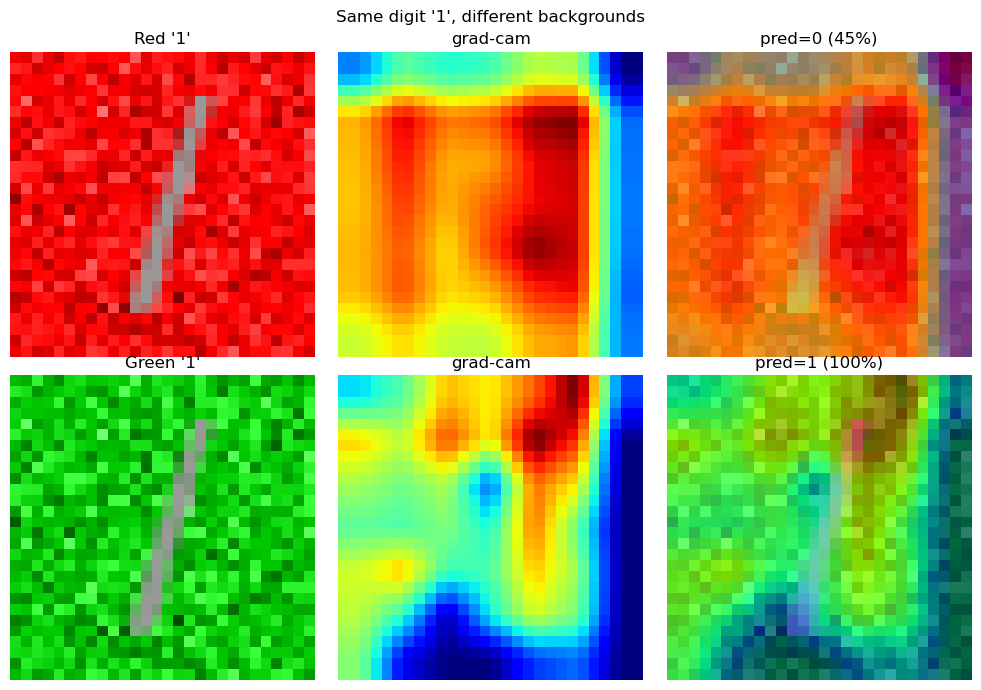

In [89]:
fig, axes = plt.subplots(2, 3, figsize=(10, 7))

gray_1 = get_digit(1)

for row, (color_idx, name) in enumerate([(0, "Red"), (1, "Green")]):
    colored = make_colored(gray_1, color_idx)
    x = colored.unsqueeze(0).to(device)
    cam, pred, conf = gradcam(x)
    
    img_np = colored.permute(1, 2, 0).numpy()
    heatmap = cm.jet(cam)[:, :, :3]
    overlay = np.clip(0.5 * img_np + 0.5 * heatmap, 0, 1)
    
    axes[row, 0].imshow(img_np)
    axes[row, 0].set_title(f"{name} '1'")
    axes[row, 0].axis("off")
    
    axes[row, 1].imshow(cam, cmap='jet')
    axes[row, 1].set_title("grad-cam")
    axes[row, 1].axis("off")
    
    axes[row, 2].imshow(overlay)
    axes[row, 2].set_title(f"pred={pred} ({conf:.0%})")
    axes[row, 2].axis("off")
    
    d_att, bg_att = attention_on_digit(gray_1, cam)
    print(f"{name} '1' → pred {pred}: {d_att:.0%} on digit, {bg_att:.0%} on background")

plt.suptitle("Same digit '1', different backgrounds", fontsize=12)
plt.tight_layout()
plt.show()

## What the Heatmaps Told Me

| Experiment | What happened |
|------------|---------------|
| Red "0" (biased) | Predicted 0 at 100% confidence. Heatmap smears across the right side of the background — barely touches the digit shape. Right answer, completely wrong reasoning. |
| Red "1" (conflict) | Predicted **0** at 45% confidence. Same broad background attention. It literally *sees* a "1" and says "0" because the background is red. |
| All 10 colors on "1" | Cheated **8 out of 9** times. Each background color → the model predicts that color's class, not "1". The heatmap patterns shift wildly across colors. |
| Attention percentages | Background gets 75–99% of attention across the board. Digit "1" on green: 8% digit / 92% background. On pink (conflict): **1% digit / 99% background**. The model is *actively ignoring* the digit. |
| Digit "0" on 4 colors | Red → pred 0 (100%). Blue → pred 2 (62%). Teal → pred 5 (94%). Black → pred 0 (89%). Totally different predictions for the *same digit*, and the heatmaps look nothing alike. |
| Red vs Green "1" | Red → pred 0 (45%), 9% on digit, 91% on background. Green → pred 1 (100%), 8% on digit, 92% on background. Same digit, same ~90% background attention, but completely different predictions. The model isn't seeing the "1" at all. |

---

## So What Does This Prove?

The Grad-CAM heatmaps make the cheating **visible**. It's not just that the model gets the wrong answer on test_hard — it's that we can literally *see* it staring at the background and ignoring the digit.

The most interesting number is that 1% digit attention on the conflicting "1" on pink. The model is putting 99% of its attention budget on the background color. It has essentially learned to be a color classifier that happens to output digit labels.

This is why Grad-CAM matters for interpretability. The accuracy numbers from Task 1 told us *that* the model cheats. The heatmaps tell us *how*. And once you can see the mechanism, you can start designing interventions to break it — which is exactly what Task 4 is about.
